Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from prettytable import PrettyTable as prt
import Augmentor
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Check CPU or GPU system
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))
print(os.getcwd())

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/home/xavier/Documents/LJMU/tensorflow_CNN


2022-10-19 22:44:06.906534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 22:44:06.911125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 22:44:06.911639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = 'Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/'
data_dir_test = 'Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Test/'
NO_CLS_OF_TRAIN = os.listdir(data_dir_train)
NO_CLS_OF_TEST = os.listdir(data_dir_test)
# Number of Class
print('No. Of class for Train:', len(NO_CLS_OF_TRAIN))
print('No. Of class for Test :', len(NO_CLS_OF_TEST))
print('Class in Train-Test:\n')
for i in zip(NO_CLS_OF_TRAIN, NO_CLS_OF_TEST):
    print(i[0]==i[1], '\t', i[0])

No. Of class for Train: 9
No. Of class for Test : 9
Class in Train-Test:

True 	 actinic keratosis
True 	 pigmented benign keratosis
True 	 dermatofibroma
True 	 nevus
True 	 seborrheic keratosis
True 	 basal cell carcinoma
True 	 vascular lesion
True 	 squamous cell carcinoma
True 	 melanoma


In [4]:
# count all the images of each class
x = prt()
x.field_names = ['Class Name', 'No. Images Train', 'No. Images Test']
for i in zip(NO_CLS_OF_TRAIN, NO_CLS_OF_TEST):
    x.add_row([i[0], len(os.listdir(data_dir_train+i[0])), len(os.listdir(data_dir_test+i[1]))])
x.align = "l"
print(x)

+----------------------------+------------------+-----------------+
| Class Name                 | No. Images Train | No. Images Test |
+----------------------------+------------------+-----------------+
| actinic keratosis          | 114              | 16              |
| pigmented benign keratosis | 462              | 16              |
| dermatofibroma             | 95               | 16              |
| nevus                      | 357              | 16              |
| seborrheic keratosis       | 77               | 3               |
| basal cell carcinoma       | 376              | 16              |
| vascular lesion            | 139              | 3               |
| squamous cell carcinoma    | 181              | 16              |
| melanoma                   | 438              | 16              |
+----------------------------+------------------+-----------------+


> __As we can see, data imbalance is quite large. However, we will train this data without the enhancement image.</br> Check the Acc results and then we will try with others the imaging technique, test it again and evaluate in this situation.</br> Besides, we try training with any model from custom to using transfer learning technology__

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## First, we load all images of each class with no images augment by use image_dataset_from_directory
## use 'batch_size'=32 and img_height, img_width = (128,128)
## Use mode of label is 'categorical' istead of 'sparseCategorical'
train_ds =  tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size=batch_size,
                                                               label_mode='categorical',
                                                               seed=123, 
                                                               image_size=(img_height, img_width),
                                                               validation_split=0.2,
                                                               subset="training")

val_ds =  tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size=batch_size,
                                                               label_mode='categorical',
                                                               seed=123, 
                                                               image_size=(img_height, img_width),
                                                               validation_split=0.2,
                                                               subset="validation")
class_names = train_ds.class_names
class_names

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2022-10-19 22:44:07.000123: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


2022-10-19 22:44:07.000445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 22:44:07.000958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 22:44:07.001432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 22:44:07.303453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 22:44:07.303921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [7]:
# Show tensor info
train_ds, val_ds

(<BatchDataset shapes: ((None, 180, 180, 3), (None, 9)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 180, 180, 3), (None, 9)), types: (tf.float32, tf.float32)>)

>__Summary with train and test data: 2239 images in 9 Class and 118 images for Test__

In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
class_names = val_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

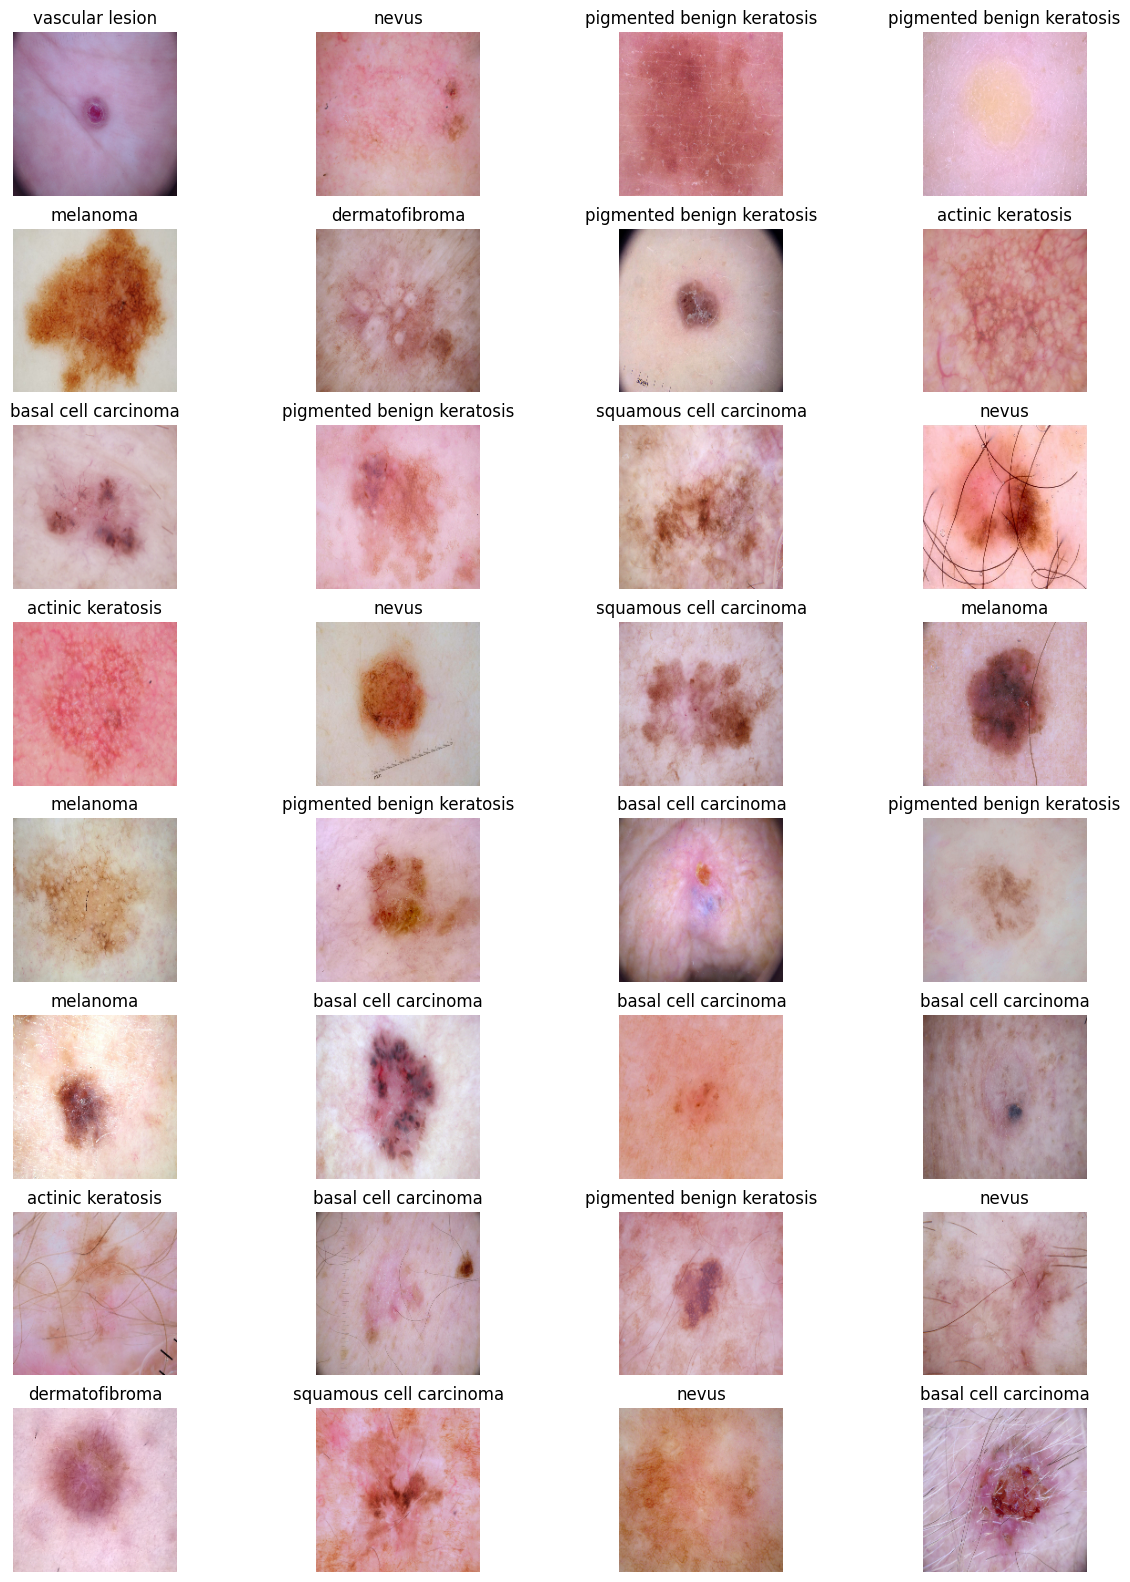

In [9]:
## Visualize Train data and Test Data

plt.figure(figsize=(15, 20))
for images, labels in train_ds.take(1):
    for i in range(batch_size):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.show()

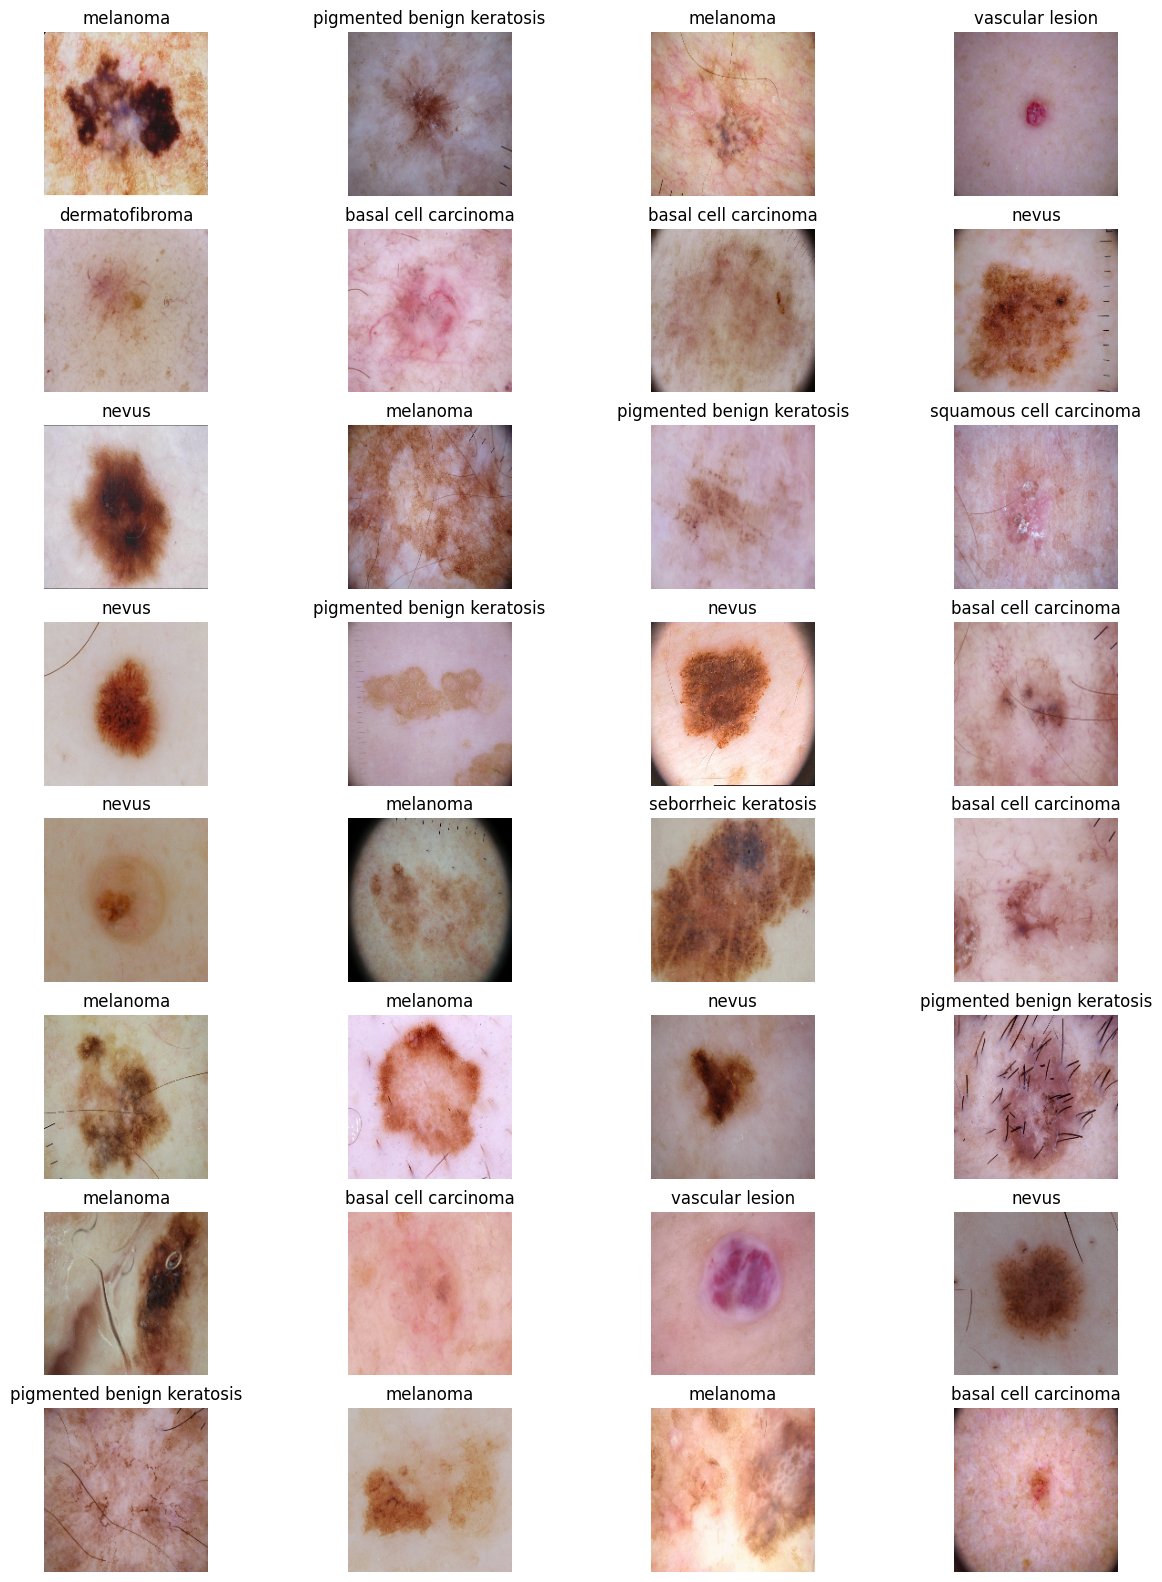

In [10]:
plt.figure(figsize=(15, 20))
for images, labels in val_ds.take(1):
    for i in range(batch_size):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Rescaling Data with pixel [0-255] to [0-1]
# scale = keras.layers.experimental.preprocessing.Rescaling(1./255)
# train_ds = train_ds.map(lambda image, label:(scale(image), label))
# val_ds = val_ds.map(lambda image, label:(scale(image), label))

> * Now, define an Architect with sequence layers, not include batch Normalization and DropOut layers.

In [13]:
## Let build model with keras Sequential()
## 
model = Sequential(name='Sequential_01')
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(len(class_names),activation='softmax'))
model.summary()

Model: "Sequential_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 85, 85, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 128)      0         
 2D)                                                 

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

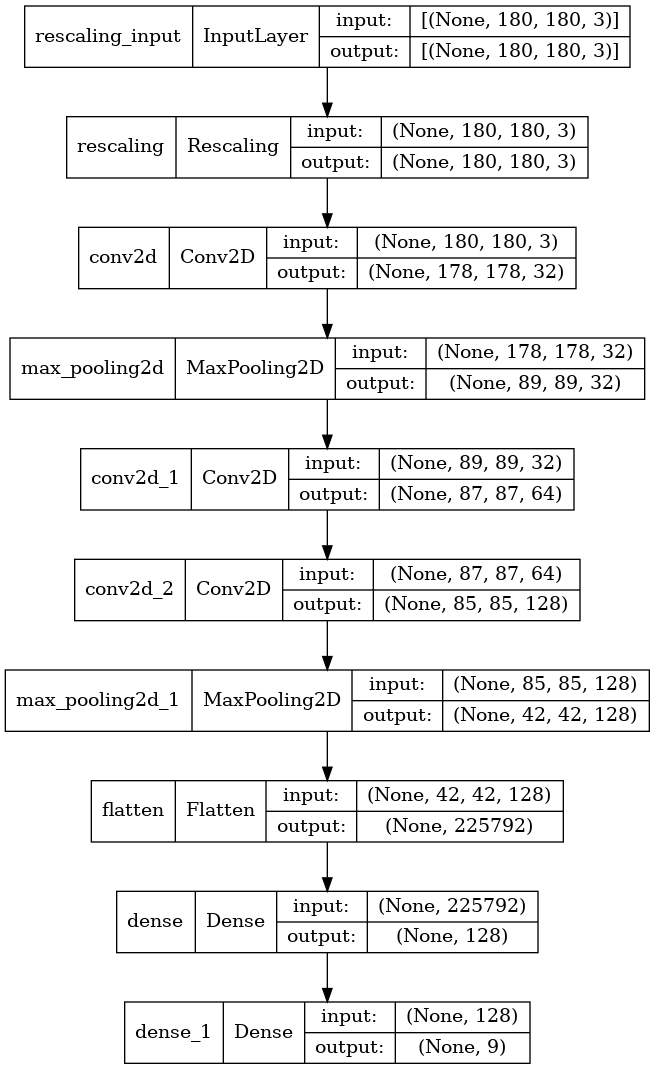

In [15]:
## Show diagrams

keras.utils.plot_model(model, show_shapes=True)

### Train the model

In [16]:
epochs = 20
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/20


2022-10-19 22:44:12.243211: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-10-19 22:44:12.698865: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-19 22:44:12.699610: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-10-19 22:44:12.699620: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-10-19 22:44:12.699657: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

56/56 [==============================] - 7s 54ms/step - loss: 2.2791 - accuracy: 0.2388 - val_loss: 1.9143 - val_accuracy: 0.2685
Epoch 2/20
56/56 [==============================] - 2s 38ms/step - loss: 1.6616 - accuracy: 0.3862 - val_loss: 1.5622 - val_accuracy: 0.4787
Epoch 3/20
56/56 [==============================] - 2s 37ms/step - loss: 1.4402 - accuracy: 0.4972 - val_loss: 1.4122 - val_accuracy: 0.5235
Epoch 4/20
56/56 [==============================] - 2s 39ms/step - loss: 1.4601 - accuracy: 0.5006 - val_loss: 1.5530 - val_accuracy: 0.4586
Epoch 5/20
56/56 [==============================] - 2s 36ms/step - loss: 1.3406 - accuracy: 0.5190 - val_loss: 1.4937 - val_accuracy: 0.4541
Epoch 6/20
56/56 [==============================] - 2s 39ms/step - loss: 1.2616 - accuracy: 0.5474 - val_loss: 1.4865 - val_accuracy: 0.4720
Epoch 7/20
56/56 [==============================] - 2s 39ms/step - loss: 1.1263 - accuracy: 0.6155 - val_loss: 1.5130 - val_accuracy: 0.5369
Epoch 8/20
56/56 [======

### Visualizing training results

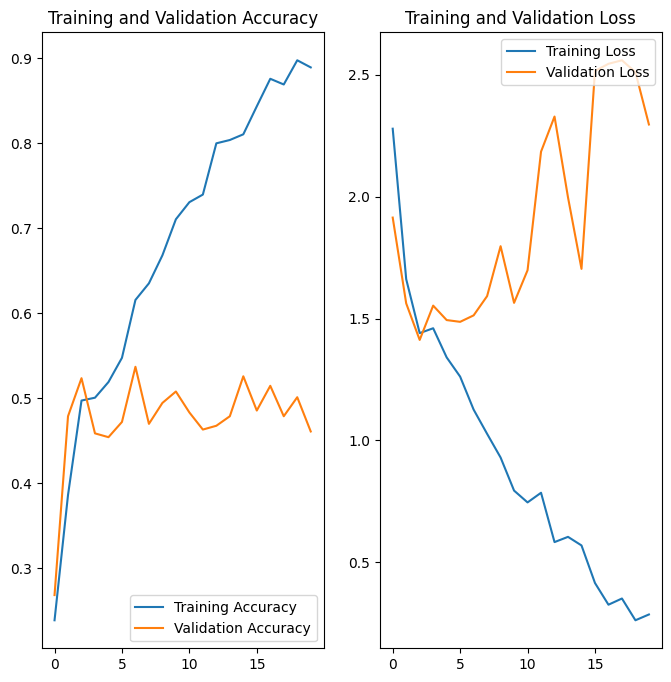

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

> * Graph denotes chaotic values. There is no specific trend.
> * In this results, model is Overfitting with high Acc on training process and bad Acc on validation process.
> * Now, we try to add BatchNormalization and Dropout and check values of model

In [18]:
## Add BatchNormalize layer, Dense and Dropout layers

model = Sequential(name='Sequential_02')

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))
model.summary()

Model: "Sequential_02"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)     

In [19]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

epochs = 20
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/20
56/56 [==============================] - 2s 26ms/step - loss: 2.0848 - accuracy: 0.1975 - val_loss: 2.0209 - val_accuracy: 0.2506
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.9808 - accuracy: 0.2634 - val_loss: 1.9393 - val_accuracy: 0.2841
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.8851 - accuracy: 0.3047 - val_loss: 1.8115 - val_accuracy: 0.2998
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.7885 - accuracy: 0.3454 - val_loss: 1.6764 - val_accuracy: 0.4161
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.6110 - accuracy: 0.4342 - val_loss: 1.5308 - val_accuracy: 0.4586
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5033 - accuracy: 0.4609 - val_loss: 1.4914 - val_accuracy: 0.4765
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4619 - accuracy: 0.4743 - val_loss: 1.4666 - val_accuracy: 0.4989
Epoch 8/20
56

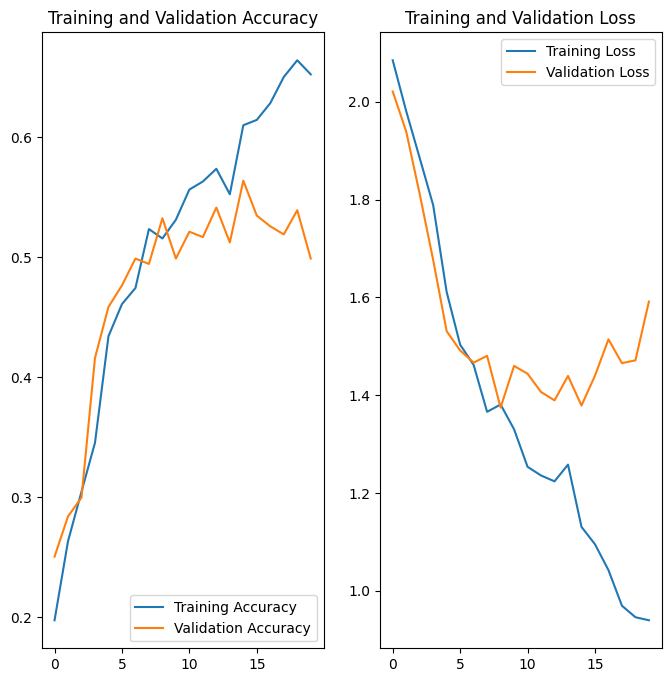

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

> __After designing new Model, Parameters in Sequential model_02 decreased from 28,995,913 to 6,648,137 with parameters Not trainable: 0 .__</br>
> __The difference between acc_train and val_acc is too big.__</br>
> __The result is still Overfitting. Let try with Augmentor Images data__

In [21]:
for i in class_names:
    p = Augmentor.Pipeline(data_dir_train + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F432097FDC0>: 100%


Initialised with 376 image(s) found.
Output directory set to Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7


Initialised with 95 image(s) found.
Output directory set to Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7


Initialised with 438 image(s) found.
Output directory set to Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F432079A850>: 100


Initialised with 357 image(s) found.
Output directory set to Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=853x680 at 0x7F432097F4F0>: 100%


Initialised with 462 image(s) found.
Output directory set to Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F43207FF250>: 100%


Initialised with 77 image(s) found.
Output directory set to Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F4320962760>: 100


Initialised with 181 image(s) found.
Output directory set to Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F43208736D0>: 100%


Initialised with 139 image(s) found.
Output directory set to Skin-cancer-ISIC-The-International-Skin-Imaging-Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F432087A790>: 100%


In [22]:
# Now check all the images were generated by Augmentor
image_augment = len(list(glob.glob(data_dir_train+'*/output/*.jpg')))
image_augment

4500

In [23]:
# Recreate data train and validation train

train_ds =  tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size=batch_size,
                                                               label_mode='categorical',
                                                               seed=123, 
                                                               image_size=(img_height, img_width),
                                                               validation_split=0.2,
                                                               subset="training")

val_ds =  tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size=batch_size,
                                                               label_mode='categorical',
                                                               seed=123, 
                                                               image_size=(img_height, img_width),
                                                               validation_split=0.2,
                                                               subset="validation")

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [24]:
## Now let check model with new datasets

model = Sequential(name='Sequential_02')

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))
model.summary()

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

learning_rate_reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                        patient=2,
                                                        verbose=1,
                                                        factor=0.2,
                                                        min_lr=1e-5)
callback = [learning_rate_reduce]

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=30,
                   callbacks=callback)

Model: "Sequential_02"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)     

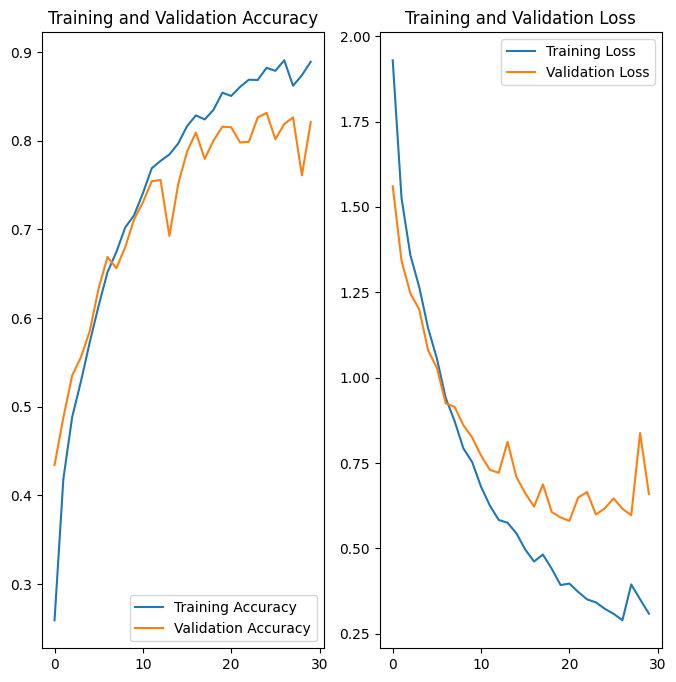

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

__The results of train and test are not consistent.</br> Although it is not high, it is still possible to see that the model is neither overfitting nor underfitting. </br> Now try to create new model with not sequential layers__

## <center>New Model defination</center>

In [26]:
# define convolution block
def conv_module(x, Nconv):
    x = keras.layers.Conv2D(Nconv, (3,3), activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    return x

# define concaternate block
def combile_module(x, Nconv1, Nconv3):
    conMat1 = conv_module(x, Nconv1)
    conMat3 = conv_module(x, Nconv3)
    x = keras.layers.concatenate([conMat1, conMat3], axis=-1)
    x = keras.layers.BatchNormalization()(x)
    return x
# define reduce block
def reduce_module(x, kernel):
    x = keras.layers.MaxPool2D(kernel)(x)
    return x

## call custom model
inpt = keras.layers.Input((180,180,3))
x = keras.layers.experimental.preprocessing.Rescaling(1./255)(inpt)
x = conv_module(x, 32)
x = reduce_module(x, (3,3))
x = combile_module(x, 16, 16)
x = reduce_module(x, (3,3))
x = conv_module(x, 16)
x = reduce_module(x, (2,2))
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(len(class_names), activation="softmax")(x)

custom_model = keras.models.Model(inpt, x, name='Custom_model')
custom_model.summary()

Model: "Custom_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 178, 178, 32  896         ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                       

__Model has a lot less total Total params (544,409/6,648,137): need to train than Sequential_02__

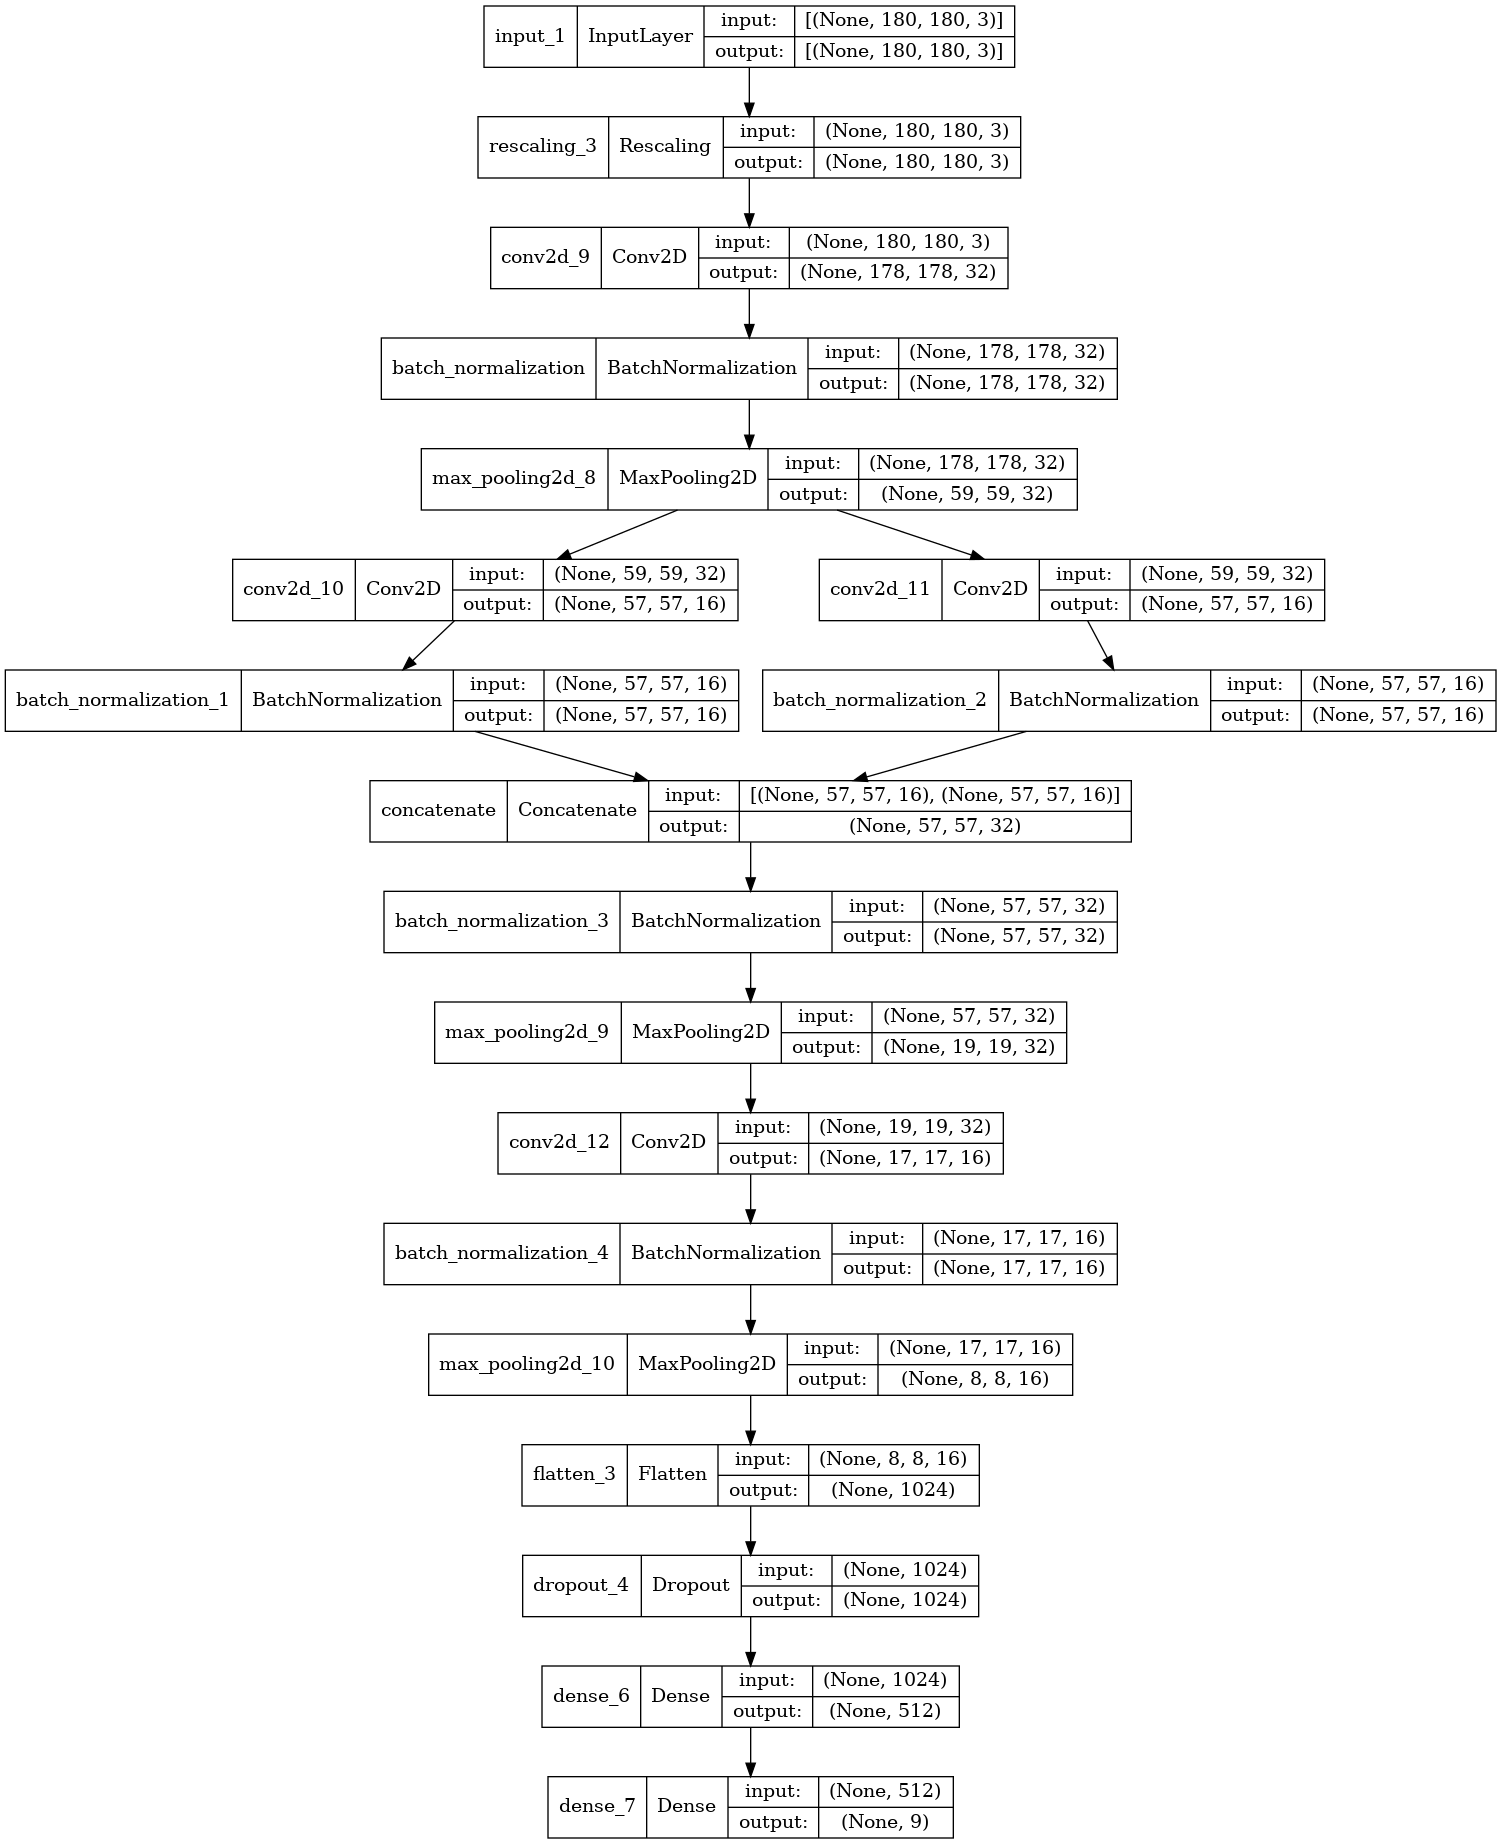

In [27]:
## Show diagrams
keras.utils.plot_model(custom_model, show_shapes=True)

In [28]:
train_ds =  tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size=batch_size,
                                                               label_mode='categorical',
                                                               seed=123, 
                                                               image_size=(img_height, img_width),
                                                               validation_split=0.2,
                                                               subset="training")

val_ds =  tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size=batch_size,
                                                               label_mode='categorical',
                                                               seed=123, 
                                                               image_size=(img_height, img_width),
                                                               validation_split=0.2,
                                                               subset="validation")

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [29]:
## create callbacks funtion with reduce learning rate
learning_rate_reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                        patient=2,
                                                        verbose=1,
                                                        factor=0.2,
                                                        min_lr=1e-5)
callback = [learning_rate_reduce]
custom_model.compile(optimizer=keras.optimizers.Adam(lr=0.0001),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
epochs = 50
history = custom_model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=callback)

Epoch 1/50
169/169 [==============================] - 5s 27ms/step - loss: 2.2236 - accuracy: 0.2947 - val_loss: 2.4326 - val_accuracy: 0.1188 - lr: 1.0000e-04
Epoch 2/50
169/169 [==============================] - 5s 27ms/step - loss: 1.6383 - accuracy: 0.4199 - val_loss: 2.0682 - val_accuracy: 0.2465 - lr: 1.0000e-04
Epoch 3/50
169/169 [==============================] - 5s 27ms/step - loss: 1.4431 - accuracy: 0.4833 - val_loss: 1.4715 - val_accuracy: 0.4529 - lr: 1.0000e-04
Epoch 4/50
169/169 [==============================] - 5s 26ms/step - loss: 1.3211 - accuracy: 0.5247 - val_loss: 1.1177 - val_accuracy: 0.5791 - lr: 1.0000e-04
Epoch 5/50
169/169 [==============================] - 5s 26ms/step - loss: 1.2138 - accuracy: 0.5597 - val_loss: 1.0411 - val_accuracy: 0.6244 - lr: 1.0000e-04
Epoch 6/50
169/169 [==============================] - 5s 26ms/step - loss: 1.1275 - accuracy: 0.5924 - val_loss: 1.0239 - val_accuracy: 0.6184 - lr: 1.0000e-04
Epoch 7/50
169/169 [====================

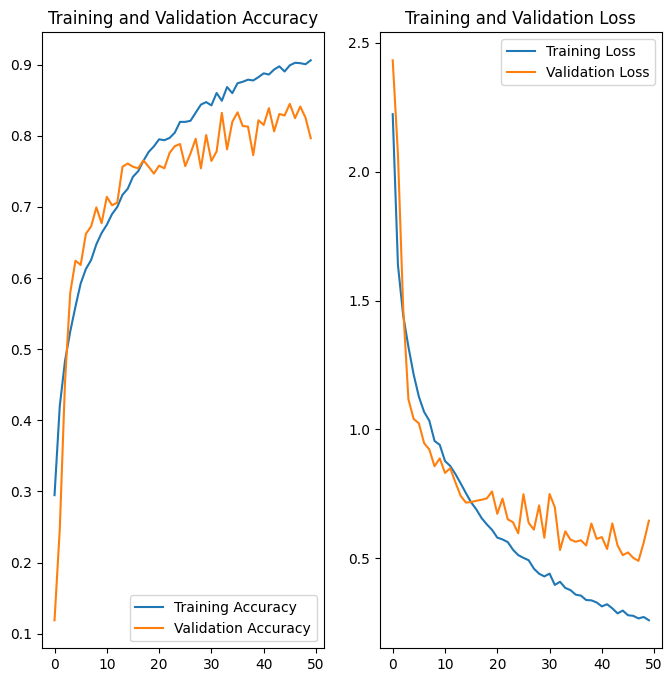

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

__model has better results on training and test sets than Sequential_02. but also not overfit__

### Now, check model to predict with test dataset

In [31]:
from PIL import Image
import pandas as pd

def predict(modelPrd, imgdir, classes):
    img = tf.keras.utils.load_img(imgdir, target_size=(180,180))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    prd = modelPrd.predict(img)
    return classes[np.argmax(prd)], round(max(prd)[0], 4)


true_cls = os.listdir(data_dir_test)# get True labels
prd_custom = []
acc_custom = []
prd_seq = []
acc_seq = []
img_name = []
true_label  = []

for cls in true_cls:
    for j in glob.glob(data_dir_test+cls+'/*.*'):
        true_label.append(cls)
        img_name.append(os.path.basename(j))
        result1 = predict(model, j, class_names)
        result2 = predict(custom_model, j, class_names)
        
        # get result of 2 model are sequential_02 and Custom_model
        prd_seq.append(result1[0])
        acc_seq.append(result1[1])
        prd_custom.append(result2[0])
        acc_custom.append(result2[1])

# Export to Dataframe        
data_result = pd.DataFrame(data={'TRUE_LABEL': true_label, 'CUSTOM_MODEL':prd_custom,
                                 'ACC_CUSTOM':acc_custom, 'SEQ_MODEL':prd_seq, 'ACC_SEQ':acc_seq})
data_result

TRUE_LABEL                CUSTOM_MODEL  ACC_CUSTOM  \
0    actinic keratosis                       nevus      0.3737   
1    actinic keratosis           actinic keratosis      0.7578   
2    actinic keratosis  pigmented benign keratosis      0.0001   
3    actinic keratosis                       nevus      0.0206   
4    actinic keratosis                       nevus      0.0000   
..                 ...                         ...         ...   
113           melanoma                       nevus      0.0000   
114           melanoma                       nevus      0.0000   
115           melanoma                    melanoma      0.0000   
116           melanoma                    melanoma      0.0005   
117           melanoma                       nevus      0.0003   

                      SEQ_MODEL  ACC_SEQ  
0    pigmented benign keratosis   0.2629  
1    pigmented benign keratosis   0.0135  
2    pigmented benign keratosis   0.0000  
3                         nevus   0.0009  
4                         nevus   0.0000  
..                          ...      ...  
113  pigmented benign keratosis   0.0000  
114  pigmented benign keratosis   0.0000  
115                    melanoma   0.0000  
116                       nevus   0.0000  
117                       nevus   0.0000  

[118 rows x 5 columns]

In [32]:
data_result[(data_result['ACC_CUSTOM']>=0.5)]
# only 2 correct predictions with Custom_model

TRUE_LABEL       CUSTOM_MODEL  ACC_CUSTOM  \
1            actinic keratosis  actinic keratosis      0.7578   
28  pigmented benign keratosis  actinic keratosis      0.6155   
34              dermatofibroma  actinic keratosis      0.8968   
67        basal cell carcinoma  actinic keratosis      0.8000   
69        basal cell carcinoma  actinic keratosis      0.7573   
76        basal cell carcinoma  actinic keratosis      0.6876   
82        basal cell carcinoma  actinic keratosis      0.8338   
92     squamous cell carcinoma  actinic keratosis      0.7073   
97     squamous cell carcinoma  actinic keratosis      0.9456   
99     squamous cell carcinoma  actinic keratosis      0.7258   

                     SEQ_MODEL  ACC_SEQ  
1   pigmented benign keratosis   0.0135  
28  pigmented benign keratosis   0.0046  
34        basal cell carcinoma   0.0707  
67  pigmented benign keratosis   0.0008  
69  pigmented benign keratosis   0.0266  
76  pigmented benign keratosis   0.0000  
82              dermatofibroma   0.0018  
92  pigmented benign keratosis   0.0323  
97  pigmented benign keratosis   0.0467  
99  pigmented benign keratosis   0.0000

In [33]:
data_result[(data_result['ACC_SEQ']>=0.5)]
# only 3 correct predictions with Sequential_02

TRUE_LABEL CUSTOM_MODEL  ACC_CUSTOM          SEQ_MODEL  ACC_SEQ
7  actinic keratosis        nevus       0.189  actinic keratosis   0.5383

> * But both of 2 model is not good with test dataset.
</br>__Based on the obtained results, we can confirm that it is impossible to apply 2 models in practice__